<a href="https://colab.research.google.com/github/SherlockHolmes5/INFX-598/blob/master/CHPT3_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST**

In [49]:
>>> from sklearn.datasets import fetch_openml
>>> mnist = fetch_openml('mnist_784', version=1)
>>> mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [50]:
mnist.data.shape

(70000, 784)

In [51]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [52]:
y.shape

(70000,)

In [53]:
28*28

784

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt

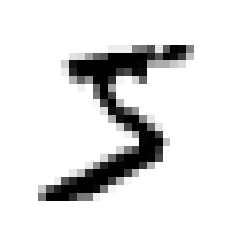

In [55]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [56]:
>>> y[0]

'5'

In [57]:
>>> y = y.astype(np.uint8)

In [58]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**TRAINING A BINARY CLASSIFIER**

In [59]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [60]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
>>> sgd_clf.predict([some_digit])

array([ True])

**PERFORMANCE MEASURES**

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [64]:
>>> from sklearn.model_selection import cross_val_score
>>> cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [66]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [67]:
>>> never_5_clf = Never5Classifier()
>>> cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**CONFUSION MATRIX**

In [68]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [69]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [70]:
>>> y_train_perfect_predictions = y_train_5 # pretend we reached perfection
>>> confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**PRECISION AND RECALL**

In [71]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [72]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [73]:
>>> from sklearn.metrics import f1_score
>>> f1_score(y_train_5, y_train_pred)

0.7325171197343846

**PRECISION/RECALL TRADE-OFF**

In [74]:
>>> y_scores = sgd_clf.decision_function([some_digit])
>>> y_scores

array([2164.22030239])

In [75]:
>>> threshold = 0
>>> y_some_digit_pred = (y_scores > threshold)

In [76]:
>>> threshold = 8000
>>> y_some_digit_pred = (y_scores > threshold)
>>> y_some_digit_pred

array([False])

In [77]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [78]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

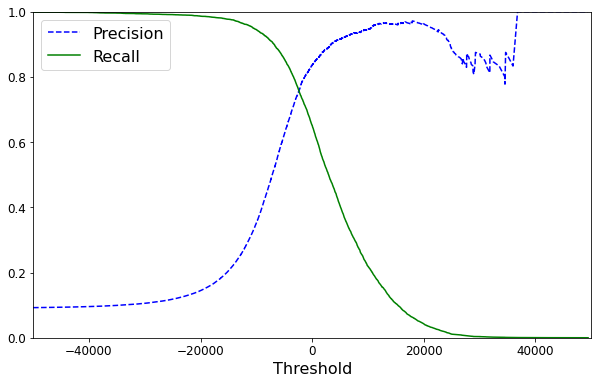

In [85]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-50000, 50000])
plt.show()

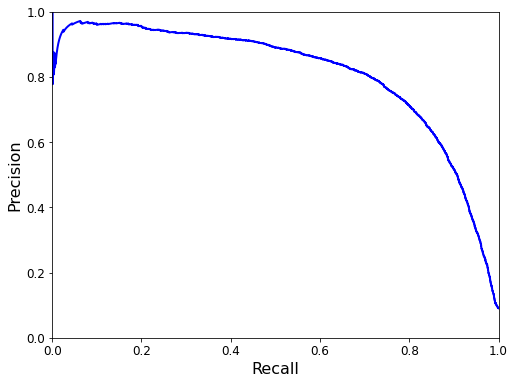

In [92]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [93]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [94]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [95]:
>>> precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [96]:
>>> recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**THE ROC CURVE**

In [97]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

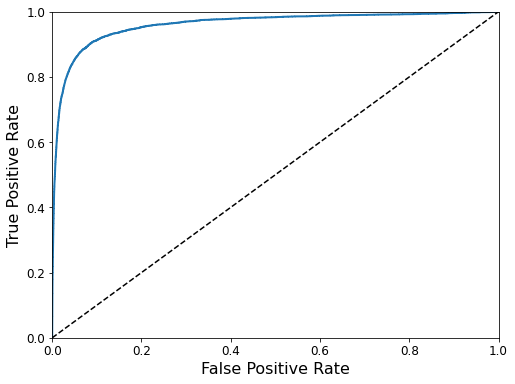

In [98]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [99]:
>>> from sklearn.metrics import roc_auc_score
>>> roc_auc_score(y_train_5, y_scores)
0.9611778893101814

0.9611778893101814

In [100]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [101]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

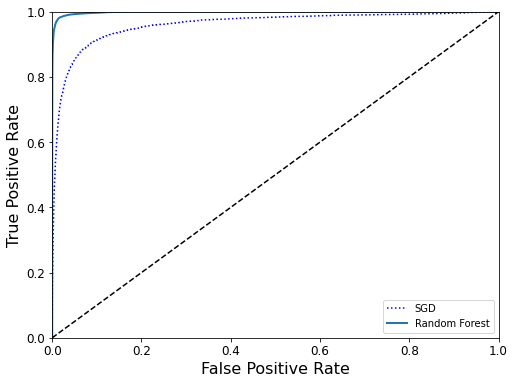

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [105]:
>>> roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [106]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [107]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

**MULTI-CLASS CLASSIFICATION**